### Celda 0: Chequeo PyTorch/CUDA
Imprime version y disponibilidad de GPU.

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.10.0.dev20251105+cu128
True


### Celda 1: Instalacion opcional Lightning
Comando pip comentado.

In [6]:
!pip install pytorch-lightning


### Celda 2: Instalacion opcional metric-learning
Comando pip comentado.

In [7]:
!pip install pytorch-metric-learning


### Celda 3: Instalacion opcional XGBoost
Comando pip comentado.

In [8]:
!pip install xgboost


### Celda 4: Imports y configuracion (contrastive)
Incluye VRAM 90% y cudnn.benchmark.

In [9]:
# ================================================================
# NOTEBOOK: Siamese Contrastive + FC + XGBoost + Embedding visuals per epoch
# ================================================================
# 0) IMPORTS
# ================================================================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.backends.cudnn as cudnn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_metric_learning.losses import ContrastiveLoss
from pytorch_metric_learning.miners import PairMarginMiner

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

# Ajustes de visualizacion
sns.set()
plt.rcParams["figure.figsize"] = (9,6)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
if device == "cuda":
    torch.cuda.set_per_process_memory_fraction(0.9, device=0)
    torch.cuda.empty_cache()
    print("VRAM limitada al 90% para este proceso")
cudnn.benchmark = True


Device: cuda
VRAM limitada al 90% para este proceso


### Celda 5: Datos y DataLoaders
Transforms, ImageFolder y DataLoaders con workers/pin_memory.

In [10]:
# ================================================================
# 1) DATA TRANSFORMS + DATASET
# ================================================================
DATASET_ROOT = r"dataset_split"

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(DATASET_ROOT, "train"), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(DATASET_ROOT, "val"),   transform=test_transform)
test_dataset  = datasets.ImageFolder(os.path.join(DATASET_ROOT, "test"),  transform=test_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

batch_size = 32
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

print("Clases detectadas:", class_names)
print(f"num_workers={num_workers}, batch_size={batch_size}")


Clases detectadas: ['Abutilon Indicum', 'Aloe barbadensis miller', 'Calotropis gigantea', 'Canna indica', 'Cissus quadrangularis', 'Curcuma longa', 'Eclipta prostrate', 'Eichhornia Crassipes', 'Hibiscus Rosasinensis', 'Ixora coccinea', 'Justica adhatoda', 'Murraya koenigii', 'Ocimum tenuiflorum', 'Ouretlanata', 'Phyllanthus amarus', 'Ricinus communis', 'Senna Atriculata', 'Sesbania grandiflora', 'Trifolium Repens', 'Ziziphus mauritiana']
num_workers=0, batch_size=32


### Celda 6: Backbone siamesa (contrastive)
ResNet50 con proyeccion a 128 dims.

In [11]:
# ================================================================
# 2) SIAMESE NETWORK
# ================================================================
class SiameseBackbone(nn.Module):
    def __init__(self, embedding_size=128):
        super().__init__()
        self.backbone = models.resnet50(weights="DEFAULT")
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, embedding_size)

    def forward(self, x):
        return self.backbone(x)

siamese = SiameseBackbone().to(device)


### Celda 7: Entrenamiento contrastive Lightning
12 epocas, precision mixta, gpu si disponible.

In [12]:
# ================================================================
# 3) PYTORCH LIGHTNING TRAINER PARA CONTRASTIVE LOSS
# ================================================================
class ContrastiveLightning(pl.LightningModule):
    def __init__(self, model, lr=1e-4):
        super().__init__()
        self.model = model
        self.miner = PairMarginMiner(pos_margin=0.5, neg_margin=1.0)
        self.loss_func = ContrastiveLoss(pos_margin=0.5, neg_margin=1.0)
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self(imgs)
        pairs = self.miner(embeddings, labels)
        loss = self.loss_func(embeddings, labels, pairs)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)

callbacks = [
    EarlyStopping(monitor="train_loss", patience=5, mode="min"),
    ModelCheckpoint(monitor="train_loss", mode="min", save_top_k=1, filename="contrastive-best")
]

lightning_model = ContrastiveLightning(siamese)
use_amp = torch.cuda.is_available()

trainer = pl.Trainer(
    max_epochs=12,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision="16-mixed" if use_amp else 32,
    gradient_clip_val=1.0,
    accumulate_grad_batches=2,
    log_every_n_steps=20,
    callbacks=callbacks,
)

trainer.fit(lightning_model, train_loader)

torch.save(siamese.state_dict(), "siamese_contrastive_backbone.pth")
print("Modelo siames guardado como siamese_contrastive_backbone.pth")


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\chori\anaconda3\envs\EXAMEN\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\chori\anaconda3\envs\EXAMEN\lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name      | Type            | Params | M

Epoch 11: 100%|██████████| 55/55 [02:28<00:00,  0.37it/s, v_num=3, train_loss=0.0166] 

`Trainer.fit` stopped: `max_epochs=12` reached.


Epoch 11: 100%|██████████| 55/55 [02:28<00:00,  0.37it/s, v_num=3, train_loss=0.0166]
Modelo siames guardado como siamese_contrastive_backbone.pth


### Celda 8: Clasificador FC
Backbone congelado, entrenamiento 30 epocas con AMP.

In [13]:
# ================================================================
# 4) CLASIFICADOR FC (BACKBONE CONGELADO)
# ================================================================
class Classifier(nn.Module):
    def __init__(self, backbone, emb_size, num_classes):
        super().__init__()
        for p in backbone.parameters():
            p.requires_grad = False
        self.backbone = backbone
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        with torch.no_grad():
            emb = self.backbone(x)
        return self.fc(emb)

classifier = Classifier(siamese, 128, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scaler = torch.cuda.amp.GradScaler(enabled=device=="cuda")

epochs_fc = 30
for epoch in range(epochs_fc):
    classifier.train()
    running_loss = 0
    for img, lbl in train_loader:
        img, lbl = img.to(device, non_blocking=True), lbl.to(device, non_blocking=True)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=device=="cuda"):
            out = classifier(img)
            loss = criterion(out, lbl)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}")

torch.save(classifier.state_dict(), "classifier_fc_contrast.pth")
print("Clasificador FC guardado como classifier_fc_contrast.pth")


C:\Users\chori\AppData\Local\Temp\ipykernel_27428\2328912910.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device=="cuda")
C:\Users\chori\AppData\Local\Temp\ipykernel_27428\2328912910.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device=="cuda"):


Epoch 1 - Loss: 2.2533
Epoch 2 - Loss: 1.1643
Epoch 3 - Loss: 0.6566
Epoch 4 - Loss: 0.4049
Epoch 5 - Loss: 0.2808
Epoch 6 - Loss: 0.2210
Epoch 7 - Loss: 0.1746
Epoch 8 - Loss: 0.1435
Epoch 9 - Loss: 0.1336
Epoch 10 - Loss: 0.1060
Epoch 11 - Loss: 0.1036
Epoch 12 - Loss: 0.0869
Epoch 13 - Loss: 0.0887
Epoch 14 - Loss: 0.0777
Epoch 15 - Loss: 0.0710
Epoch 16 - Loss: 0.0651
Epoch 17 - Loss: 0.0641
Epoch 18 - Loss: 0.0635
Epoch 19 - Loss: 0.0647
Epoch 20 - Loss: 0.0595
Epoch 21 - Loss: 0.0628
Epoch 22 - Loss: 0.0572
Epoch 23 - Loss: 0.0471
Epoch 24 - Loss: 0.0581
Epoch 25 - Loss: 0.0501
Epoch 26 - Loss: 0.0492
Epoch 27 - Loss: 0.0561
Epoch 28 - Loss: 0.0539
Epoch 29 - Loss: 0.0578
Epoch 30 - Loss: 0.0539
Clasificador FC guardado como classifier_fc_contrast.pth


### Celda 9: Evaluacion clasificador FC
Accuracy y F1 macro en test.

In [14]:
# ================================================================
# 5) EVALUACION DEL CLASIFICADOR FC
# ================================================================
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            p = out.argmax(1).cpu().numpy()
            preds.extend(p)
            labels.extend(y.numpy())

    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="macro")
    return acc, f1, labels, preds

acc, f1, y_true, y_pred = evaluate(classifier, test_loader)

print("Accuracy FC:", acc)
print("F1-score FC:", f1)


Accuracy FC: 0.9873417721518988
F1-score FC: 0.9881143272186101


### Celda 9.1: Matriz de confusion del clasificador FC (checkpoint)
Evalua `classifier_fc_contrast.pth` en test y genera la matriz de confusion y reporte.

==== Eval FC (checkpoint classifier_fc_contrast.pth) ====
Accuracy: 0.9873 | Macro-F1: 0.9881
Reporte:                         precision    recall  f1-score   support

       Abutilon Indicum     1.0000    0.9615    0.9804        26
Aloe barbadensis miller     1.0000    1.0000    1.0000        23
    Calotropis gigantea     1.0000    0.8824    0.9375        17
           Canna indica     1.0000    1.0000    1.0000        23
  Cissus quadrangularis     1.0000    1.0000    1.0000        21
          Curcuma longa     1.0000    1.0000    1.0000        17
      Eclipta prostrate     0.9143    1.0000    0.9552        32
   Eichhornia Crassipes     1.0000    1.0000    1.0000        31
  Hibiscus Rosasinensis     1.0000    1.0000    1.0000        18
         Ixora coccinea     1.0000    1.0000    1.0000        18
       Justica adhatoda     1.0000    1.0000    1.0000        15
       Murraya koenigii     0.9048    1.0000    0.9500        19
     Ocimum tenuiflorum     1.0000    0.9375    0.96

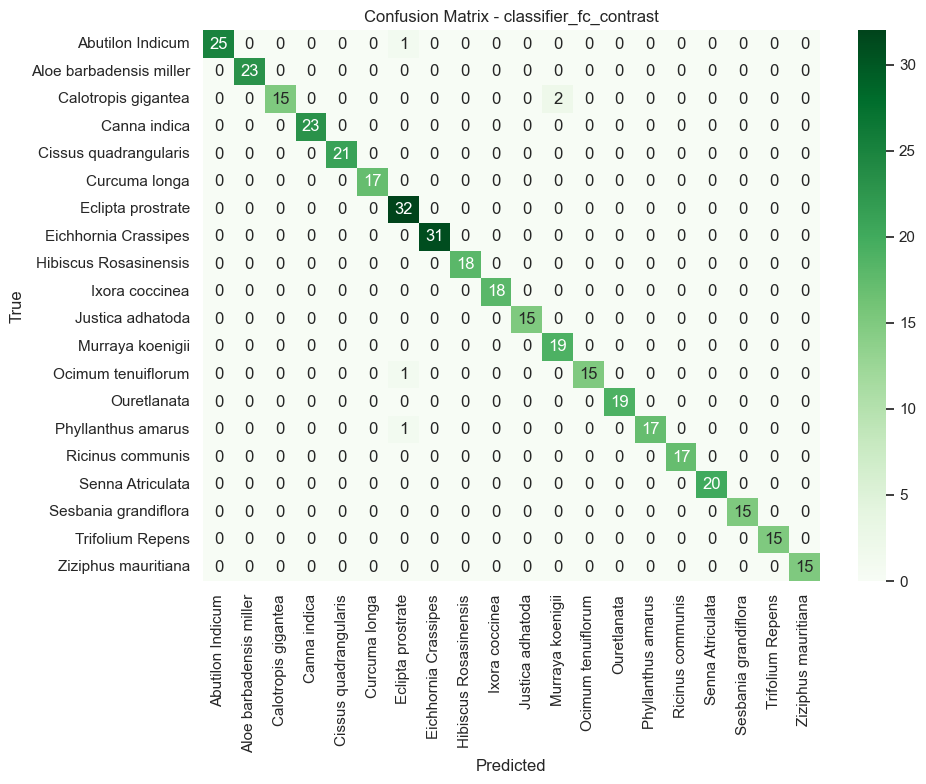

Matriz de confusion guardada en results_fc_contrastive\confmat_classifier_fc_contrast.png


In [15]:
from pathlib import Path

ckpt_backbone = Path("siamese_contrastive_backbone.pth")
ckpt_classifier = Path("classifier_fc_contrast.pth")

backbone_eval = SiameseBackbone(embedding_size=128).to(device)
if ckpt_backbone.exists():
    backbone_eval.load_state_dict(torch.load(ckpt_backbone, map_location=device))

classifier_eval = Classifier(backbone_eval, 128, num_classes).to(device)
classifier_eval.load_state_dict(torch.load(ckpt_classifier, map_location=device))
classifier_eval.eval()

all_labels, all_preds = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = classifier_eval(images)
        preds = outputs.argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

acc_ckpt = accuracy_score(all_labels, all_preds)
f1_ckpt = f1_score(all_labels, all_preds, average="macro")
cm_ckpt = confusion_matrix(all_labels, all_preds)
report_ckpt = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

print("==== Eval FC (checkpoint classifier_fc_contrast.pth) ====")
print(f"Accuracy: {acc_ckpt:.4f} | Macro-F1: {f1_ckpt:.4f}")
print("Reporte:" + report_ckpt)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_ckpt, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - classifier_fc_contrast")
confmat_dir = Path("results_fc_contrastive")
confmat_dir.mkdir(exist_ok=True, parents=True)
confmat_file = confmat_dir / "confmat_classifier_fc_contrast.png"
plt.tight_layout()
plt.savefig(confmat_file, dpi=300)
plt.show()
print(f"Matriz de confusion guardada en {confmat_file}")


### Celda 10: Extraccion de embeddings para XGBoost
Genera embeddings y labels para train/test.

In [16]:
# ================================================================
# 6) EXTRAER EMBEDDINGS (PARA XGBOOST)
# ================================================================
def extract_embeddings(model, loader):
    model.eval()
    all_emb, all_lbl = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = model(x).cpu().numpy()
            all_emb.append(emb)
            all_lbl.append(y.numpy())

    return np.vstack(all_emb), np.hstack(all_lbl)

train_emb, train_lbl = extract_embeddings(siamese, train_loader)
test_emb,  test_lbl  = extract_embeddings(siamese, test_loader)

print("Embeddings shape:", train_emb.shape)


Embeddings shape: (1751, 128)


### Celda 11: Visualizacion embeddings 2D
PCA/TSNE scatter por clase.

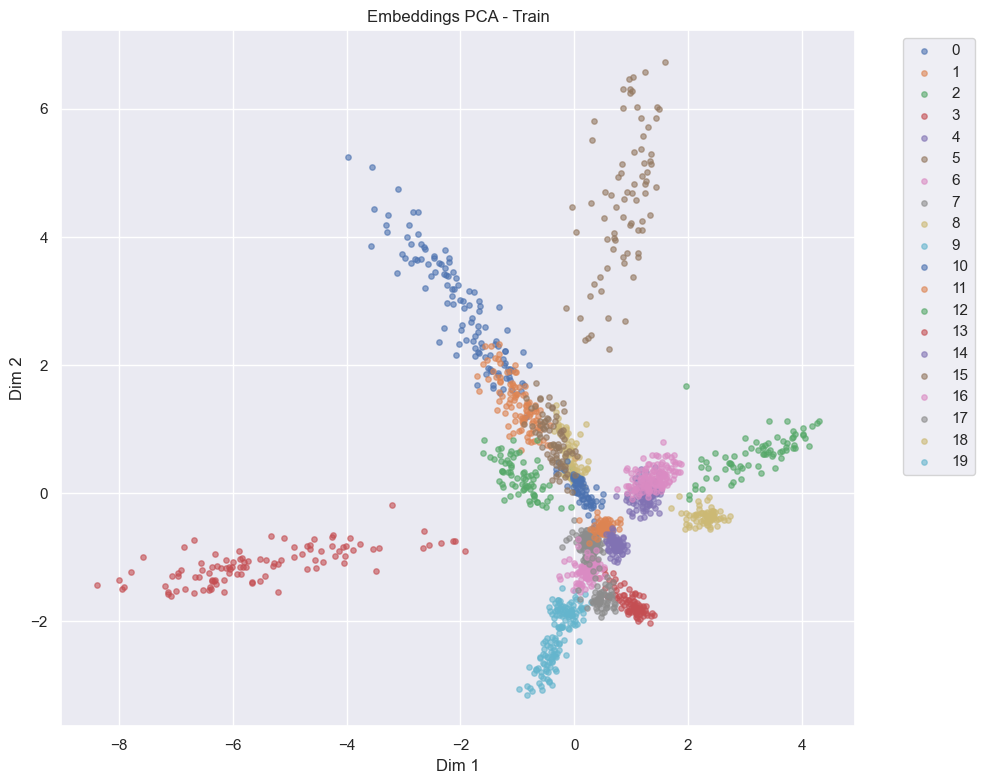

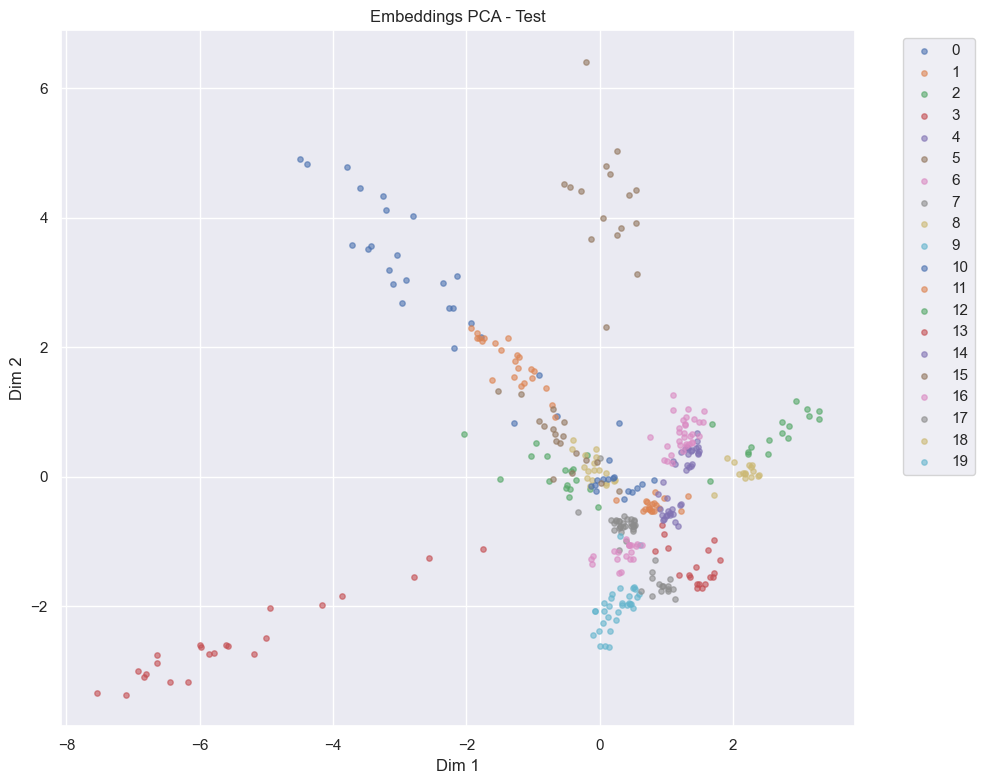

In [17]:
# ================================================================
# 6.1) VISUALIZAR EMBEDDINGS EN 2D
# ================================================================
def plot_embeddings(embeddings, labels, method="pca", title="Embeddings 2D"):
    """
    embeddings: np.array (N, embedding_dim)
    labels: np.array (N,)
    method: "pca" o "tsne"
    """
    if method.lower() == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        reducer = PCA(n_components=2)
        
    emb_2d = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    num_classes = len(np.unique(labels))
    for c in range(num_classes):
        idx = labels == c
        plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=str(c), alpha=0.6, s=15)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

# Visualizar embeddings de entrenamiento
plot_embeddings(train_emb, train_lbl, method="pca", title="Embeddings PCA - Train")

# Visualizar embeddings de test
plot_embeddings(test_emb, test_lbl, method="pca", title="Embeddings PCA - Test")

### Celda 12: XGBoost sobre embeddings
Entrena, evalua, reporta y conf matrix.

WARN: XGBoost sin soporte GPU; cambiando a CPU (hist/predictor=auto)


c:\Users\chori\anaconda3\envs\EXAMEN\lib\site-packages\xgboost\training.py:199: UserWarning: [03:12:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


==== Evaluacion XGBoost (CPU) ====
Accuracy: 0.9544 | Macro-F1: 0.9536
Reporte:                         precision    recall  f1-score   support

       Abutilon Indicum     1.0000    0.8846    0.9388        26
Aloe barbadensis miller     0.9583    1.0000    0.9787        23
    Calotropis gigantea     1.0000    0.8824    0.9375        17
           Canna indica     0.9200    1.0000    0.9583        23
  Cissus quadrangularis     1.0000    1.0000    1.0000        21
          Curcuma longa     0.8947    1.0000    0.9444        17
      Eclipta prostrate     0.9143    1.0000    0.9552        32
   Eichhornia Crassipes     1.0000    0.9355    0.9667        31
  Hibiscus Rosasinensis     1.0000    0.9444    0.9714        18
         Ixora coccinea     1.0000    0.9444    0.9714        18
       Justica adhatoda     0.6818    1.0000    0.8108        15
       Murraya koenigii     0.9412    0.8421    0.8889        19
     Ocimum tenuiflorum     1.0000    0.8750    0.9333        16
          

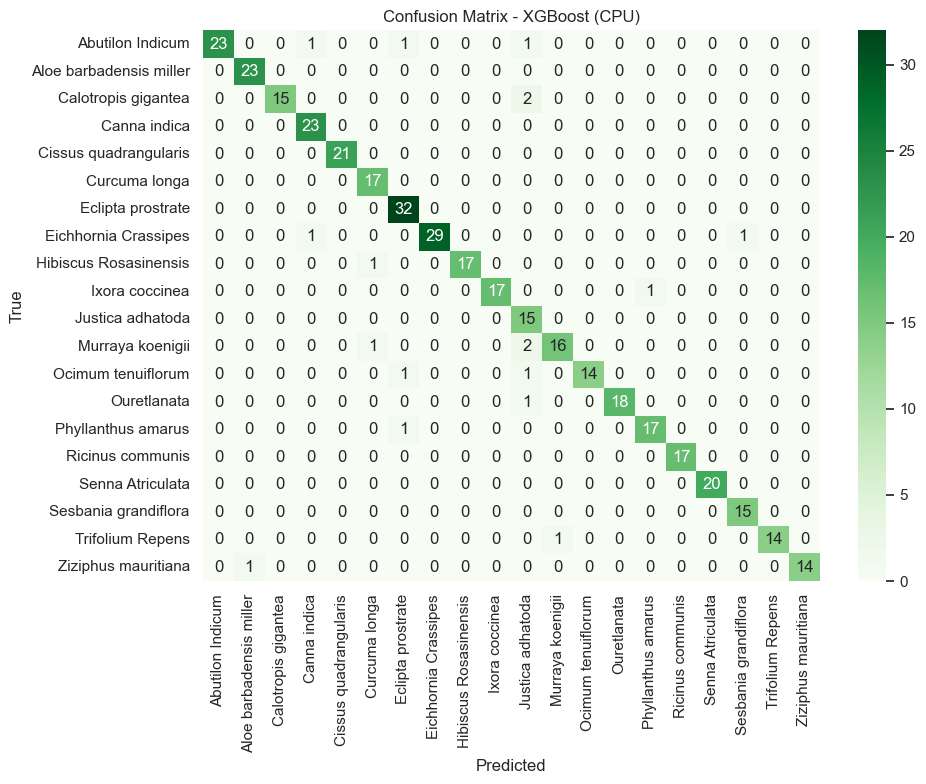

Matriz de confusion guardada en results_xgb_contrastive\confmat_xgb_contrastive.png
Predicciones guardadas en results_xgb_contrastive\preds_xgb_contrastive.csv
Metricas guardadas en results_xgb_contrastive\metrics_xgb_contrastive.csv


In [18]:
# ================================================================
# 7) XGBOOST PARA CLASIFICAR EMBEDDINGS
# ================================================================
from xgboost.core import XGBoostError

RESULTS_DIR_XGB = Path("results_xgb_contrastive")
RESULTS_DIR_XGB.mkdir(exist_ok=True, parents=True)
LABEL_NAMES = class_names

def build_xgb_params(use_gpu: bool):
    params = dict(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='mlogloss'
    )
    if use_gpu:
        params.update(tree_method="gpu_hist", predictor="gpu_predictor")
    else:
        params.update(tree_method="hist", predictor="auto")
    return params

use_gpu = torch.cuda.is_available()
params = build_xgb_params(use_gpu)

try:
    xgb = XGBClassifier(**params)
    xgb.fit(train_emb, train_lbl)
except XGBoostError as e:
    msg = str(e).lower()
    if use_gpu and ("gpu_hist" in msg or "gpu_predictor" in msg):
        print("WARN: XGBoost sin soporte GPU; cambiando a CPU (hist/predictor=auto)")
        params = build_xgb_params(False)
        xgb = XGBClassifier(**params)
        xgb.fit(train_emb, train_lbl)
        use_gpu = False
    else:
        raise

xgb_preds = xgb.predict(test_emb)

acc_xgb = accuracy_score(test_lbl, xgb_preds)
f1_xgb  = f1_score(test_lbl, xgb_preds, average="macro")
cm_xgb = confusion_matrix(test_lbl, xgb_preds)
report_xgb = classification_report(test_lbl, xgb_preds, target_names=LABEL_NAMES, digits=4)
backend = "GPU" if use_gpu else "CPU"

print(f"==== Evaluacion XGBoost ({backend}) ====")
print(f"Accuracy: {acc_xgb:.4f} | Macro-F1: {f1_xgb:.4f}")
print("Reporte:" + report_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix - XGBoost ({backend})")
confmat_path = RESULTS_DIR_XGB / "confmat_xgb_contrastive.png"
plt.tight_layout(); plt.savefig(confmat_path, dpi=300); plt.show()
print(f"Matriz de confusion guardada en {confmat_path}")

preds_df = pd.DataFrame({
    "filepath": [p for p,_ in test_dataset.samples][:len(test_lbl)],
    "true_label": [LABEL_NAMES[i] for i in test_lbl],
    "pred_label": [LABEL_NAMES[i] for i in xgb_preds],
})
preds_df["correct"] = preds_df["true_label"] == preds_df["pred_label"]
preds_csv = RESULTS_DIR_XGB / "preds_xgb_contrastive.csv"
preds_df.to_csv(preds_csv, index=False)

metrics_df = pd.DataFrame([{"accuracy": acc_xgb, "macro_f1": f1_xgb, "backend": backend}])
metrics_csv = RESULTS_DIR_XGB / "metrics_xgb_contrastive.csv"
metrics_df.to_csv(metrics_csv, index=False)

print(f"Predicciones guardadas en {preds_csv}")
print(f"Metricas guardadas en {metrics_csv}")


### Celda 13: Matriz de confusion XGBoost (legacy)
Referenciada por la celda anterior.

In [19]:
# Matriz de confusion ya generada en la celda de XGBoost.

### Celda 14: Guardado de modelos
Backbone, FC y XGBoost.

In [20]:
# ================================================================
# 9) GUARDAR MODELOS
# ================================================================
torch.save(siamese.state_dict(), "siamese_contrastive_backbone.pth")
torch.save(classifier.state_dict(), "classifier_fc_contrast.pth")
xgb.save_model("xgboost_contrastive.json")
print("Modelos guardados en la carpeta del notebook")


Modelos guardados en la carpeta del notebook


### Celda 15: Script de inferencia final
Carga modelos guardados y reporta metricas.

In [23]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from xgboost import XGBClassifier

# ------------------------------
# Configuración
# ------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_ROOT = "dataset_split"  # Cambia según tu ruta
batch_size = 32

# ------------------------------
# Transformaciones del test set
# ------------------------------
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_dataset = datasets.ImageFolder(os.path.join(DATASET_ROOT, "test"), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# ------------------------------
# Reconstruir la red siamesa
# ------------------------------
class SiameseBackbone(torch.nn.Module):
    def __init__(self, embedding_size=128):
        super().__init__()
        self.backbone = models.resnet50(weights="DEFAULT")
        self.backbone.fc = torch.nn.Linear(self.backbone.fc.in_features, embedding_size)

    def forward(self, x):
        return self.backbone(x)

siamese = SiameseBackbone(embedding_size=128).to(device)
siamese.load_state_dict(torch.load("siamese_contrastive_backbone.pth", map_location=device))
siamese.eval()

# ------------------------------
# Extraer embeddings del test set
# ------------------------------
def extract_embeddings(model, loader):
    model.eval()
    all_emb, all_lbl = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = model(x).cpu().numpy()
            all_emb.append(emb)
            all_lbl.append(y.numpy())
    return np.vstack(all_emb), np.hstack(all_lbl)

test_emb, test_lbl = extract_embeddings(siamese, test_loader)

# ------------------------------
# Cargar XGBoost
# ------------------------------
xgb = XGBClassifier()
xgb.load_model("xgboost_contrastive.json")
xgb_preds = xgb.predict(test_emb)

# ------------------------------
# Métricas finales
# ------------------------------
acc = accuracy_score(test_lbl, xgb_preds)
precision = precision_score(test_lbl, xgb_preds, average="macro")
f1 = f1_score(test_lbl, xgb_preds, average="macro")
cm = confusion_matrix(test_lbl, xgb_preds)

print("🎯 XGBoost Test Accuracy :", acc)
print("⚡ XGBoost Test Precision:", precision)
print("🔥 XGBoost Test F1-score :", f1)
print("Matriz de confusión (normalizada):")
print(cm)


🎯 XGBoost Test Accuracy : 0.9544303797468354
⚡ XGBoost Test Precision: 0.9596147493287587
🔥 XGBoost Test F1-score : 0.9535875625525474
Matriz de confusión (normalizada):
[[23  0  0  1  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 29  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  1  0  0 17  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  2 16  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  1  0 14  0  0  0  0  0  0  0]
 [ 0  0  0 